# **News Recommendation System using Cosine Similarity**

- In the era of information overload, analyzing text data has become a crucial task for extracting meaningful insights and enhancing user experience. This project focuses on the application of Natural Language Processing (NLP) techniques to explore the similarities among news. By leveraging the power of cosine similarity, we aim to uncover relationships between different news articles based on their content.

- The project utilizes the Term Frequency-Inverse Document Frequency (TF-IDF) vectorization method to transform textual data into numerical format. Following this transformation, cosine similarity is calculated to measure the degree of similarity between different summaries in the dataset. Our dataset comprises news summaries from various categories, providing a rich ground for analysis and exploration.

- The dataset can be accessed from [Statso's News Recommendation Case Study](https://statso.io/news-recommendation-case-study/).



<div style="text-align: center;">
    <img src="https://www.datahen.com/blog/content/images/size/w2000/wordpress/2017/07/News-media-standards.jpg" alt="Image">
</div>

### Importing the necessary packages

In [46]:
import pandas as pd
import plotly.express as px
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import spatial
import warnings
warnings.filterwarnings('ignore')

import re
import nltk 
nltk.download('punkt','stopwords')
from nltk.corpus import stopwords
import random
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to stopwords...
[nltk_data]   Package punkt is already up-to-date!


### Importing the data

In [29]:
df = pd.read_csv('News.csv')

### EDA - Exploratoy Data Analysis 

In [30]:
df.head()

,ID,News Category,Title,Summary
0,N88753,lifestyle,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the..."
1,N45436,news,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on l...
2,N23144,health,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...
3,N86255,health,Dispose of unwanted prescription drugs during ...,NaN
4,N93187,news,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...


In [31]:
df.shape

(101527, 4)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101527 entries, 0 to 101526
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ID             101527 non-null  object
 1   News Category  101527 non-null  object
 2   Title          101527 non-null  object
 3   Summary        96112 non-null   object
dtypes: object(4)
memory usage: 3.1+ MB


In [33]:
df.isnull().sum()

ID                  0
News Category       0
Title               0
Summary          5415
dtype: int64

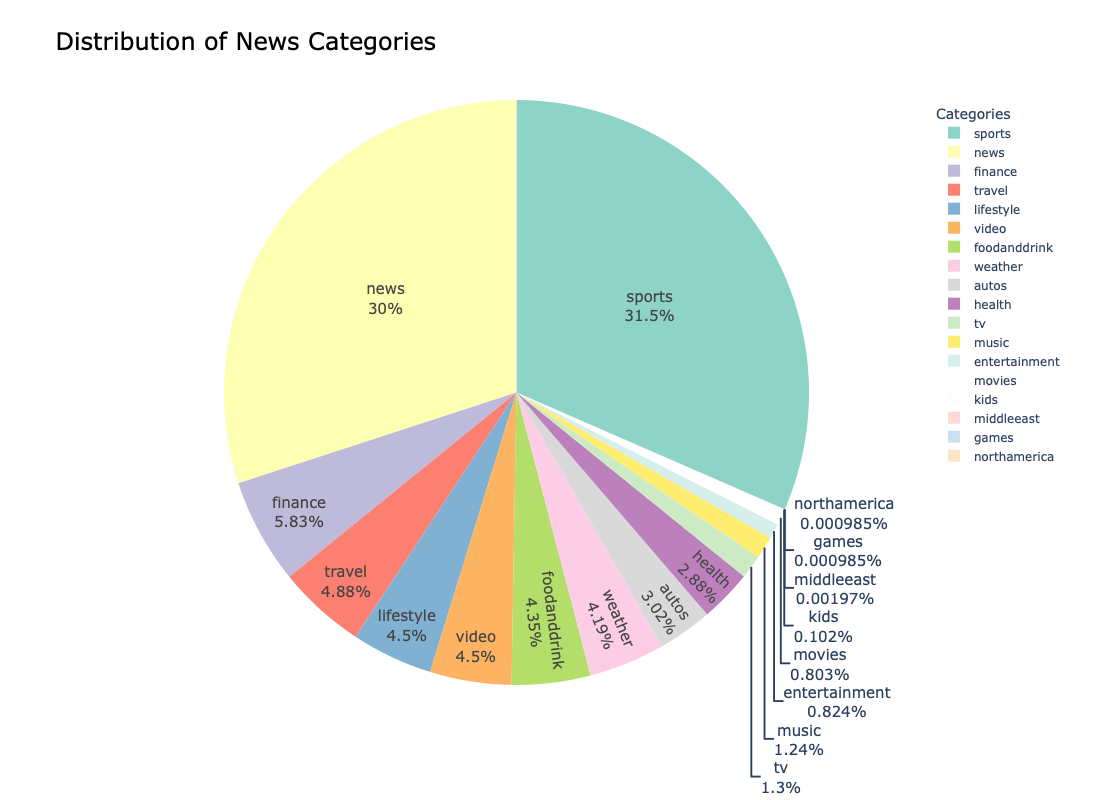

In [34]:
#distribution of news categories
category_counts = df['News Category'].value_counts().reset_index()
category_counts.columns = ['News Category', 'Count']

fig = px.pie(category_counts, values='Count', names='News Category', 
             title='Distribution of News Categories',
             color_discrete_sequence=px.colors.qualitative.Set3)
fig.update_traces(textinfo='percent+label', textfont_size=15)
fig.update_layout(title_font_size=24, title_font_color='black', legend_title_text='Categories', width=1000, height=800)
fig.show()

### Feature Engineering

In [35]:
#dropping the rows where 'Products.short_description' is missing
df=df.dropna(subset=['Summary'],how='any')

In [36]:
#reseting the index of the DataFrame
df=df.reset_index(drop=True)

In [37]:
#text cleaning
def clean_text(column):
    column = column.str.lower()
    column = column.str.replace(r'[^\w\s]', '', regex=True)
    column = column.str.replace(r'\d+', '', regex=True)
    column = column.str.replace('\n', '', regex=True)
    column = column.str.replace('\r', '', regex=True)
    return column

df['Summary'] = clean_text(df['Summary'])

In [38]:
#initializing a list to hold filtered texts
filtered_texts = []

#tokenization and stopword removal for the 'Summary' column
for summary in df['Summary']:
    tokens = word_tokenize(summary)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    filtered_text = ' '.join(filtered_tokens)
    filtered_texts.append(filtered_text)

#adding a new column to the DataFrame with the cleaned text
df['filtered_summary'] = filtered_texts

In [39]:
df['filtered_summary'][3500]

'see favorite stars looked like school find kind students'

In [40]:
#TF-IDF vectorization
tfidf_vect = TfidfVectorizer(stop_words='english' )
tfidf_matrix = tfidf_vect.fit_transform(df['filtered_summary']) #fitting and transforming the filtered descriptions into a TF-IDF matrix

In [41]:
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix) #creating a sparse dataframe from the TF-IDF matrix

In [42]:
tfidf_df.shape

(96112, 80753)

In [43]:
#combining dataframes
df = pd.concat([df, tfidf_df], axis=1)

In [44]:
df.sample(5)

,ID,News Category,Title,Summary,filtered_summary,0,1,2,3,4,...,80743,80744,80745,80746,80747,80748,80749,80750,80751,80752
791,N102670,news,15-year-old killed in suspected DUI crash in P...,a carmichael man was arrested on suspicion of ...,carmichael man arrested suspicion dui crashed ...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65161,N28114,travel,Firefighter taken to hospital battling 2nd fir...,firefighters were battling a fire in lewiston ...,firefighters battling fire lewiston wednesday ...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9190,N1683,video,Kitten About to Fall Asleep in Coffee Mug,one very sleepy kitty looked like it needed co...,one sleepy kitty looked like needed coffee tar...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9908,N44225,tv,Ashton Kutcher's new reality show wants to giv...,ashton kutchers new reality show wants to give...,ashton kutchers new reality show wants give fi...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49157,N1110,health,Mom of Two Shares Her Breast Cancer Battle: 'G...,jennie smythe had no idea her life was about t...,jennie smythe idea life change walked routine ...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Utilizing cosine similarity with 10% of the data through random sampling

In [45]:
sampled_df = df.sample(frac=0.1, random_state=42)  

#TF-IDF vectorization
tfidf_vect = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vect.fit_transform(sampled_df['filtered_summary'])

#calculating the cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

#creating a DataFrame for sosine similarity**
cosine_sim_df = pd.DataFrame(cosine_sim, columns=sampled_df.index, index=sampled_df.index)
print(cosine_sim_df)

       32561  52625  55515     95751     36140     19848  40845  84898  \
32561    1.0    0.0    0.0  0.000000  0.000000  0.000000    0.0    0.0   
52625    0.0    1.0    0.0  0.000000  0.000000  0.000000    0.0    0.0   
55515    0.0    0.0    1.0  0.000000  0.000000  0.000000    0.0    0.0   
95751    0.0    0.0    0.0  1.000000  0.000000  0.008518    0.0    0.0   
36140    0.0    0.0    0.0  0.000000  1.000000  0.000000    0.0    0.0   
...      ...    ...    ...       ...       ...       ...    ...    ...   
47354    0.0    0.0    0.0  0.017131  0.000000  0.000000    0.0    0.0   
65559    0.0    0.0    0.0  0.000000  0.009905  0.044247    0.0    0.0   
7620     0.0    0.0    0.0  0.000000  0.000000  0.000000    0.0    0.0   
17906    0.0    0.0    0.0  0.000000  0.000000  0.038158    0.0    0.0   
25670    0.0    0.0    0.0  0.000000  0.000000  0.000000    0.0    0.0   

          49435     22585  ...     8887      29217     35601     90165  \
32561  0.000000  0.000000  ...  0.000

### Finding the 5 most similar rows in the summary column

In [47]:
N = 5
similar_summaries = {}
for idx in range(cosine_sim.shape[0]):
    similar_indices = cosine_sim[idx].argsort()[-(N+1):-1][::-1]
    similar_summaries[idx] = similar_indices

sampled_docs = random.sample(list(similar_summaries.keys()), min(10, len(similar_summaries)))
for doc_idx in sampled_docs:
    similar_idx = similar_summaries[doc_idx]
    print(f"summary {doc_idx} is most similar to the following {N} summaries: {similar_idx}")

summary 2984 is most similar to the following 5 summaries: [7931 9136  214 3552 1894]
summary 9216 is most similar to the following 5 summaries: [6538 9545 2322 5148 6324]
summary 6296 is most similar to the following 5 summaries: [1775 4665  540 2550 9065]
summary 4140 is most similar to the following 5 summaries: [9519  208 2153 5462 5885]
summary 3548 is most similar to the following 5 summaries: [6302 7884 6923 6441 4752]
summary 9127 is most similar to the following 5 summaries: [6436 6998 8028 3049  809]
summary 3421 is most similar to the following 5 summaries: [ 543 9017 4756  207   79]
summary 8088 is most similar to the following 5 summaries: [2812 6668 5639 5995 2076]
summary 8772 is most similar to the following 5 summaries: [5638 3124 5218 6179 2707]
summary 452 is most similar to the following 5 summaries: [6178 7959  728 1250  717]


### Analyzing the similarities found using cosine similarity

In [36]:
similar_indices = [84, 5884, 640, 6022, 6037]
summary_0_text = sampled_df['Summary'].iloc[0]
print(f"summary 0: '{summary_0_text}' is most similar to the following summaries:")

for index in similar_indices:
    if index < len(sampled_df):
        similar_text = sampled_df['Summary'].iloc[index]
        print(f" - summary {index}: '{similar_text}'")

summary 0: 'homewood memorial gardens is a south suburban cemetery that made headlines for all the wrong reasons back in  now some people with loved ones buried there say there are still problems today' is most similar to the following summaries:
 - summary 84: 'the battle over a pet cemetery in baltimore county is mounting as its owner faces an ultimatum dozens of pets are buried in the oakleigh pet cemetery in parkville which has  acres of property filled with tombstones many of which are cracked and unkempt but all with names of beloved pets sign up for our newsletters the cemetery dates back to the s when families would bury their pets in grand fashion cynthia eisenrauch grew up across'
 - summary 5884: 'the riverdale star died in march of a massive stroke and his loved ones have paid tribute in many ways in the months since'
 - summary 640: 'recently one operator said he was driving tired after  hours on shift and accidentally took a wrong turn dropping off a train full of people 

In [37]:
similar_indices = [2278, 2528, 6084, 8654, 9384] 
summary_1_text = sampled_df['Summary'].iloc[1]
print(f"summary 1: '{summary_1_text}' is most similar to the following summaries:")

for index in similar_indices:
    if index < len(df):
        similar_text = sampled_df['Summary'].iloc[index]
        print(f" - summary {index}: '{similar_text}'")

summary 1: 'danielle niles has your latest weather forecast' is most similar to the following summaries:
 - summary 2278: 'meteorologist danielle niles celebrated her final day at wbztv thursday morning with a surprise from her daughter charlotte'
 - summary 2528: 'zack green has your latest weather forecast'
 - summary 6084: 'david epstein has your latest weather forecast'
 - summary 8654: 'sarah wroblewski has your latest weather forecast'
 - summary 9384: 'barry burbank has your latest weather forecast'


In [38]:
similar_indices = [3257, 3575, 4535, 4177, 1621]
summary_125_text = sampled_df['Summary'].iloc[1]
print(f"summary 125: '{summary_125_text}' is most similar to the following summaries:")

for index in similar_indices:
    if index < len(df):
        similar_text = sampled_df['Summary'].iloc[index]
        print(f" - summary {index}: '{similar_text}'")

summary 125: 'danielle niles has your latest weather forecast' is most similar to the following summaries:
 - summary 3257: 'on the road to  again'
 - summary 3575: 'north glebe road has reopened to traffic near chain bridge following fridays water main break officials said crews will return to the area for followup work on the roadway and the inch pipe that broke the inch pipe broke on chain bridge road and glebe road in arlington virginia causing a boil water advisory for northwest dc and arlington county fairfax county police said chain bridge road reopened after route  near the'
 - summary 4535: 'the mount hope bridge which connects portsmouth and bristol opened on oct   it was the longest suspension bridge in new england until the newport pell bridge opened in june '
 - summary 4177: 'the trucks brakes failed as the driver was traveling up a hill on myrtle avenue in englewood authorities said'
 - summary 1621: 'salt trucks are in place after rain changed to snow overnight and temp

In [45]:
#top similar 5 summaries
N = 5
all_similarities = []

for idx in range(len(cosine_sim)):
    similar_indices = cosine_sim[idx].argsort()[-(N+1):-1][::-1]
    similar_scores = cosine_sim[idx][similar_indices]
    for sim_idx, score in zip(similar_indices, similar_scores):
        if sim_idx != idx:
            all_similarities.append((idx, sim_idx, score))

all_similarities.sort(key=lambda x: x[2], reverse=True)

print(f"Top {N} similar summaries:")
for doc_idx, sim_idx, score in all_similarities[:N]:
    print(f"Summary {doc_idx} is similar to Summary {sim_idx} (Score: {score:.2f})")

Top 5 similar summaries:
Summary 1756 is similar to Summary 5346 (Score: 1.00)
Summary 8968 is similar to Summary 9493 (Score: 1.00)
Summary 306 is similar to Summary 6065 (Score: 1.00)
Summary 353 is similar to Summary 1242 (Score: 1.00)
Summary 759 is similar to Summary 988 (Score: 1.00)


In [50]:
#similarity scores of the most similar documents
for idx in range(len(cosine_sim)):
    similar_indices = cosine_sim[idx].argsort()[-(N+1):-1][::-1]
    print(f"summary {idx} similar summaries and scores:")
    for sim_idx in similar_indices:
        print(f" - summary {sim_idx} (Score: {cosine_sim[idx][sim_idx]:.2f})")

summary 0 similar summaries and scores:
 - summary 84 (Score: 0.16)
 - summary 5884 (Score: 0.15)
 - summary 640 (Score: 0.15)
 - summary 6022 (Score: 0.14)
 - summary 6037 (Score: 0.14)
summary 1 similar summaries and scores:
 - summary 2278 (Score: 0.42)
 - summary 2528 (Score: 0.41)
 - summary 6084 (Score: 0.41)
 - summary 8654 (Score: 0.37)
 - summary 9384 (Score: 0.36)
summary 2 similar summaries and scores:
 - summary 7884 (Score: 0.30)
 - summary 1703 (Score: 0.26)
 - summary 3347 (Score: 0.21)
 - summary 4872 (Score: 0.20)
 - summary 675 (Score: 0.20)
summary 3 similar summaries and scores:
 - summary 6071 (Score: 0.26)
 - summary 9338 (Score: 0.24)
 - summary 7456 (Score: 0.20)
 - summary 2665 (Score: 0.17)
 - summary 1967 (Score: 0.16)
summary 4 similar summaries and scores:
 - summary 3163 (Score: 0.12)
 - summary 7965 (Score: 0.12)
 - summary 8766 (Score: 0.11)
 - summary 369 (Score: 0.10)
 - summary 7768 (Score: 0.10)
summary 5 similar summaries and scores:
 - summary 1478

## Results and Evaluation

The analysis revealed significant insights into the similarities among news summaries. Using cosine similarity, we identified the top similar summaries for each article in our dataset. Additionally, the top 5 similar summaries identified for various articles demonstrated the potential for creating a recommendation system that suggests articles based on user interests and reading history.

The insights gained from this project have several real-world applications:

- **News Aggregation Platforms**: By implementing a content-based recommendation system, news platforms can enhance user engagement by suggesting articles that align with readers' interests, improving the overall user experience.
  
- **Personalized News Feeds**: Media outlets can utilize our approach to create personalized news feeds for users, tailoring content to individual preferences and past reading behavior.

- **Research and Analysis Tools**: Researchers can use this methodology to analyze trends in news reporting, discovering how similar topics are covered across different outlets.

By employing these techniques, organizations can not only improve user satisfaction but also drive higher engagement rates, ultimately leading to a more informed and connected audience.